In [1]:
#%% Modules
###############################################################################
import pandas as pd                                     ## Dataframes
import numpy as np                                      ## Numeric methods
import statsmodels as sm                                ## Statistical models
import statsmodels.formula.api as smf                   ## Formulas
import time
from sklearn.preprocessing import scale 

# Quantile regression results stopping on crisis date, dependent variable is one year later

In [2]:
class QuantileReg(object):
    """ 
    Fit a conditional regression model, via quantile regressions

    Inputs:
    - depvar: string, dependent variable 
    - indvars: list of independent variables
    - quantile_list: list of quantiles to run the fit on
    - data = data to train the model on
    - scaling: zscore of the variables: standardized coefficients
    - alpha: the level of confidence to compute the confidence intervals
    
    Output:
    - qfit_dict = regressions fit, per quantiles (statsmodels object)
    - mfit = OLS regression fit, for the conditional mean
    - coeff = coefficients of the quantile regression, for every quantile
    - cond_quant: conditional quantiles and mean 

    Usage:
    qr = QuantileReg('y_growth_fwd_4', indvars=p_indvars, quantile_list=ql,
                     data=df, scaling=True, alpha=0.2)

    """
    __description = "Conditional quantiles, based on quantile regressions"
    __author = "Romain Lafarguette, IMF/MCM, rlafarguette@imf.org"

    ## Initializer
    def __init__(self, depvar, indvars, quantile_list, data, scaling=True,
                 alpha=0.1):

        ## Parameters
        self.scaling = scaling
        self.alpha = alpha
        self.quantile_list = quantile_list
        
        ## Variables
        self.depvar = depvar

        ## Data cleaning for the regression
        self.data = data.dropna()


        ## All data
        
        ## List of regressors
        self.regressors = [x for x in indvars if x in self.data.columns]

        ## Formula regression
        self.reg_formula = self.__reg_formula()
        
        ## Depending on user input, scale the variables
        vars_reg = [self.depvar] + self.regressors
        if self.scaling == True:
            self.data.loc[:, vars_reg] = scale(self.data.loc[:, vars_reg])
        else:
            pass
        
        ## From class methods (see below)
        self.qfit_dict = self.__qfit_dict()
        self.mfit = self.__mfit()
        self.coeff = self.__coeff()

        ## Conditional quantiles: use as predictors the historical regressors
        ## Basically, in-sample prediction but can be customized
        self.cond_quant = self.cond_quantiles(predictors=data)
        
    ## Methods
    def __reg_formula(self):
        """ Specify the formula for the quantile regressions """
        regressors_l = self.regressors[0]
        for v in self.regressors[1:]: regressors_l += ' + {0}'.format(v)
        reg_f = '{0} ~ {1}'.format(self.depvar, regressors_l)
        return(reg_f)

    def __qfit_dict(self): 
        """ Estimate the fit for every quantiles """
        qfit_dict = dict()
        for tau in self.quantile_list:
            reg_f = self.reg_formula
            qfit = smf.quantreg(formula=reg_f, data=self.data).fit(q=tau,
                                                                   maxiter=2000,
                                                                   p_tol=1e-05)


            qfit_dict[tau] = qfit
        return(qfit_dict)

    def __mfit(self): 
        """ Estimate the fit for every quantiles """
        mfit = smf.ols(self.reg_formula, data=self.data).fit()
        return(mfit)
    
    def __coeff(self):
        """ Extract the parameters and package them into pandas dataframe """
        params = pd.DataFrame()
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            stats = [qfit.params,qfit.pvalues,qfit.conf_int(alpha=self.alpha)]
            stats_names = ['coeff', 'pval', 'lower', 'upper']
            dp = pd.concat(stats, axis=1); dp.columns = stats_names
            dp.insert(0, 'quantile', qfit.q) # Insert as a first column
            dp['R2_in_sample'] = qfit.prsquared
            #dp = dp.loc[dp.index != 'Intercept',:].copy()
            ## Add the scaling information
            dp.loc[:,'normalized'] = self.scaling
            params = pd.concat([params, dp], axis=0) #params = params.append(dp)
        
        ## For information,  coeffs from an OLS regression (conditional mean)
        mfit = self.mfit
        stats = [mfit.params, mfit.pvalues, mfit.conf_int(alpha=self.alpha)]
        stats_names = ['coeff', 'pval', 'lower', 'upper']
        dmp = pd.concat(stats, axis=1); dmp.columns = stats_names
        dmp.insert(0, 'quantile', 'mean') # Insert as a first column
        dmp['R2_in_sample'] = mfit.rsquared
        #dmp = dmp.loc[dmp.index != 'Intercept',:].copy()
        ## Add the scaling information
        dmp.loc[:,'normalized'] = self.scaling
        coeff = pd.concat([params, dmp], axis='index')
        
        ## Return the full frame
        return(coeff)
    
    def cond_quantiles(self, predictors):
        """ 
        Estimate the conditional quantiles in sample 
        - Predictors have to be a pandas dataframe with regressors as columns
        """
        cond_quantiles = pd.DataFrame()
                
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            # Run the prediction over a predictors frame     
            dc = qfit.get_prediction(exog=predictors).summary_frame()
            dc.columns = ['conditional_quantile_' + x for x in dc.columns]    
            ## Insert extra information            
            dc.insert(0, 'tau', tau)
            dc = dc.set_index(predictors.index)
            dc.insert(1, 'realized_value', predictors.loc[:, self.depvar])    
            cond_quantiles = pd.concat([cond_quantiles, dc], axis=0) #cond_quantiles = cond_quantiles.append(dc)  
                        
        ## Add the conditional mean
        dm = self.mfit.get_prediction(exog=predictors).summary_frame()
        dm.columns = ['conditional_quantile_' + x for x in dm.columns]    
        dm.insert(0, 'tau', 'mean')
        dm = dm.set_index(predictors.index)

        ## Insert the realized value (depvar is y(t+h))
        dm.insert(1, 'realized_value', predictors.loc[:, self.depvar])
        
        ## Concatenate both frames
        cq = pd.concat([cond_quantiles, dm])

        return(cq)

In [3]:
FCI = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\Data\FCIdatamonth.19.csv')
FCI['Date'] = pd.date_range(start='2004-01-31', end='2019-11-30', freq='M')
FCI.set_index('Date', inplace=True)
FCI.drop(['date'], axis=1, inplace=True)
FCI

,external,macrodomestic,priceofrisk,ratepressure
Date,,,,
2004-01-31,0.812910,2.002493,1.000421,0.545327
2004-02-29,0.794679,1.710869,0.784259,0.187986
2004-03-31,1.385136,2.700241,0.669097,1.099579
2004-04-30,1.702268,2.336171,0.300671,1.040979
2004-05-31,2.067763,2.909243,0.149910,-0.197503
...,...,...,...,...
2019-07-31,-0.633585,-0.551228,4.551460,0.441210
2019-08-31,-0.761449,-0.511280,4.986199,1.483409
2019-09-30,-0.835120,0.445903,6.871285,2.278374


In [5]:
all = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\alldatanonscaled.csv')
all['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
all.set_index('Date', inplace=True)
all.drop(['Unnamed: 0'], axis=1, inplace=True)
all = all[:'2019-11-30'] #stop at crisis date
all

,Term,Interbank,Sov,LBPratespread,USDratespread,CDratespread,LBPdeprate,USDdeprate,EMP,Financialdoll,...,passenger outflow,Construction permits,Cement deliveries,portinflowpc,portoutflowpc,passengerinflowpc,passengeroutflowpc,Constructionpermitspc,Cementdeliveriespc,Dummy_variable2006
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,2.52,4.00,6.23,3.60,5.21,-3.15,7.55,3.41,-0.124678,0.660648,...,129296.533653,849400.862149,267932.293006,-0.192316,0.184994,0.352923,0.202067,0.169653,0.058940,0
2004-02-29,2.60,3.50,6.23,3.69,5.23,-3.03,7.43,3.37,-0.547668,0.660485,...,142375.338880,726957.789232,288217.845090,0.217461,0.699338,-0.058631,0.034067,0.180729,0.755790,0
2004-03-31,2.66,6.00,6.37,3.84,5.23,-2.86,7.26,3.32,0.796238,0.664061,...,107144.439167,712790.968052,182508.803423,0.189919,0.518380,0.546469,0.397163,0.605989,-0.033003,0
2004-04-30,2.71,3.75,5.86,3.99,4.97,-2.73,7.13,3.30,0.301791,0.667326,...,125017.667638,776099.605205,207343.194048,-0.290181,0.405922,0.742473,0.630778,0.122211,-0.336039,0
2004-05-31,2.69,4.00,5.38,4.00,5.01,-2.66,7.06,3.23,-1.463656,0.668629,...,133736.186995,613967.912496,196035.369395,-0.315968,0.264171,0.348978,0.381865,-0.307480,0.284919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,1.82,5.00,5.28,2.32,3.89,-3.91,8.81,6.01,-0.905691,0.717579,...,410227.619844,667586.972958,329304.698804,-0.152309,-0.047158,0.018639,0.047088,-0.047905,-0.240342,0
2019-08-31,1.82,6.00,5.55,2.29,3.81,-4.05,8.95,6.20,0.997338,0.729057,...,389753.340318,510122.507982,289055.678423,-0.180367,-0.134782,0.004105,0.025707,-0.274212,-0.261129,0
2019-09-30,1.82,25.00,5.47,1.79,3.69,-4.23,9.13,6.57,1.991244,0.750590,...,336261.453260,482604.398607,298466.654118,-0.230567,-0.118224,-0.046339,-0.035443,-0.228269,-0.235140,0


In [6]:
gdpdf = pd.concat([all['gdp'], all['gdp3'], all['gdp6'], all['gdp12']], axis = 1)
gdpdf

,gdp,gdp3,gdp6,gdp12
Date,,,,
2004-01-31,0.075949,0.084416,0.076923,0.023529
2004-02-29,0.143791,0.100000,0.088608,-0.080000
2004-03-31,0.133803,0.097403,0.082803,0.031056
2004-04-30,0.084416,0.076923,0.055556,0.005988
2004-05-31,0.100000,0.088608,0.071429,0.042424
...,...,...,...,...
2019-07-31,-0.009772,-0.090615,-0.125000,-0.500000
2019-08-31,-0.016835,-0.132911,-0.134228,-0.506849
2019-09-30,-0.027397,-0.116279,-0.354839,-0.443662


In [7]:
#Scale gdp 
gdp_s = scale(gdpdf)
gdp_s = pd.DataFrame(gdp_s, columns=['gdp_s', 'gdp3_s', 'gdp6_s', 'gdp12_s'])
gdp_s['Date'] = pd.date_range(start='2004-01-31', end='2019-11-30', freq='M')
gdp_s.set_index('Date', inplace=True)
gdp_s

,gdp_s,gdp3_s,gdp6_s,gdp12_s
Date,,,,
2004-01-31,0.421097,0.566520,0.463633,0.062200
2004-02-29,1.313978,0.765916,0.584374,-0.741155
2004-03-31,1.182523,0.732683,0.524388,0.120603
2004-04-30,0.532523,0.470657,0.242833,-0.073915
2004-05-31,0.737634,0.620155,0.406856,0.208818
...,...,...,...,...
2019-07-31,-0.707106,-1.672910,-1.622929,-4.000219
2019-08-31,-0.800065,-2.214074,-1.718289,-4.053367
2019-09-30,-0.939077,-2.001271,-3.997957,-3.563054


In [11]:
df = pd.concat([FCI, gdp_s['gdp_s'], gdp_s['gdp12_s'], all['Dummy_variable2006']], axis=1)
df

,external,macrodomestic,priceofrisk,ratepressure,gdp_s,gdp12_s,Dummy_variable2006
Date,,,,,,,
2004-01-31,0.812910,2.002493,1.000421,0.545327,0.421097,0.062200,0
2004-02-29,0.794679,1.710869,0.784259,0.187986,1.313978,-0.741155,0
2004-03-31,1.385136,2.700241,0.669097,1.099579,1.182523,0.120603,0
2004-04-30,1.702268,2.336171,0.300671,1.040979,0.532523,-0.073915,0
2004-05-31,2.067763,2.909243,0.149910,-0.197503,0.737634,0.208818,0
...,...,...,...,...,...,...,...
2019-07-31,-0.633585,-0.551228,4.551460,0.441210,-0.707106,-4.000219,0
2019-08-31,-0.761449,-0.511280,4.986199,1.483409,-0.800065,-4.053367,0
2019-09-30,-0.835120,0.445903,6.871285,2.278374,-0.939077,-3.563054,0


<Axes: xlabel='Date'>

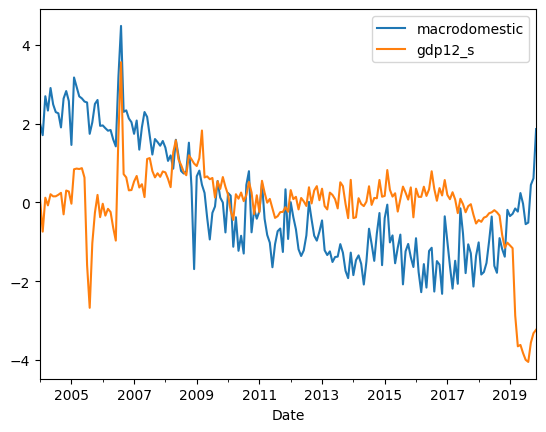

In [12]:
df[['macrodomestic', 'gdp12_s']].plot()

In [13]:
indvars = df[['external','priceofrisk', 'gdp_s', 'macrodomestic', 'ratepressure', 'Dummy_variable2006']] #'priceofrisk', 

In [14]:
ql = [0.05, 0.1, 0.5, 0.7, 0.9]

In [15]:
Qresult = QuantileReg('gdp12_s', indvars=indvars , quantile_list=ql, data=df, scaling=True, alpha=0.2)

In [16]:
Qresult.coeff

,quantile,coeff,pval,lower,upper,R2_in_sample,normalized
Intercept,0.05,-9.423229e-01,4.004867e-46,-1.005081,-0.879565,0.694481,True
external,0.05,-2.432850e-01,3.835461e-07,-0.302687,-0.183883,0.694481,True
priceofrisk,0.05,-1.184917e+00,2.242200e-27,-1.303555,-1.066279,0.694481,True
gdp_s,0.05,2.601383e-01,5.643876e-16,0.222496,0.297781,0.694481,True
macrodomestic,0.05,5.813858e-01,3.376272e-25,0.519630,0.643141,0.694481,True
ratepressure,0.05,-3.546681e-02,6.990650e-01,-0.153281,0.082348,0.694481,True
Dummy_variable2006,0.05,3.585205e-01,8.182135e-62,0.340296,0.376745,0.694481,True
Intercept,0.1,-8.632843e-01,8.698272e-35,-0.935597,-0.790971,0.574021,True
external,0.1,-2.684414e-01,8.142570e-07,-0.336049,-0.200833,0.574021,True
priceofrisk,0.1,-1.169711e+00,9.277242e-25,-1.295509,-1.043914,0.574021,True


# Ploting

In [17]:
#import os, sys, importlib                             ## Operating system
import pandas as pd                                   ## Dataframes
import numpy as np                                    ## Numeric tools
import matplotlib.pyplot as plt                       ## Plotting
import seaborn as sns                                 ## Plotting
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

In [18]:
#%% Plotting
###############################################################################
## Style of the charts
plt.style.use('seaborn-white')

## Charting parameters : size
from pylab import rcParams
plt.close('all')  

C:\Users\jadfa\AppData\Local\Temp\ipykernel_1500\2319076150.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [19]:
#%% Coefficients plotting
###############################################################################
def coeff_plot(dcoeffc, regressors, qlist):
    plt.close('all')    
    qlist.sort()
    
    for i in range(len(qlist)):
        if qlist[i]==0.5:
            ind05=i
            break
    qlist.insert(ind05,'mean')
    ## Prepare the coefficient frame
#    dcoeff = frames_dict['Quant reg coefficients']
#    dcoeffc = dcoeff[(dcoeff[group] == group_value)]
#    dcoeffc = dcoeffc.rename(columns={'coeff':'standardized coefficient'}) 
    dcoeffc['errors'] = (dcoeffc['upper'] - dcoeffc['lower'])/2

    ## Variables text
    variable_list_coeff = regressors

    #variable_list_label = {'autoregressive':'Autoregressive',
#                           'prices':'Price of Risk',
#                           'quantities': 'Leverage',
#                           'foreign': 'External'}
    
    ## Define the grid
    n=len(variable_list_coeff)
    fig = plt.figure(figsize=(8*min(4,n+1),6*((n+1)//4+1)+4))
    axes=[]
    gs = GridSpec((n+1)//4+1, min(4,n+1))
    for i in range(n+1):
        axes.append(fig.add_subplot(gs[i//4,i%4]))
    ## Plots    
    
    for v, variable in enumerate(variable_list_coeff):
        vs=variable.split('_trans_')
        varn=vs[0]
        if len(vs) > 4 and vs[1][-4:] != 'None':
                varn += '_' + vs[1]
        if len(varn)>20:
            variable_label = varn[:17]+'...'
        else:
            variable_label = varn
            
        dcv = dcoeffc.loc[dcoeffc.index == variable, :].copy()
        dcv = dcv.reset_index()
        dcv = dcv.set_index(dcv['quantile'])
        dcv = dcv.reindex(qlist)
        erna=dcv['errors'].isnull().any()
            # Plot the coefficients
        if erna:
            dcv['coeff'].plot.bar(color='blue',ax=axes[v])
            x=max(abs(min(dcv['coeff'].values)),abs(max(dcv['coeff'].values)))
        else:
            dcv['coeff'].plot.bar(color='blue',yerr = dcv.errors,ax=axes[v])
            x=max(abs(min(dcv['lower'].values)),abs(max(dcv['upper'].values)))
        axes[v].axhline(y=0, c='black', linewidth=0.7)
        axes[v].set_title('{0}'.format(variable_label), fontsize=25, y=1.05)
        axes[v].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[v].set_xlabel('')
    
        axes[v].set_ylim(-x-0.1,x+0.1)
        axes[v].tick_params(labelsize=25)
        
        # Plot the R2
    dcv['R2_in_sample'].plot.bar(color='blue', ax=axes[n])
    axes[n].set_title('R2: ', fontsize=25, y=1.05)
    axes[n].set_xlabel('')
    axes[n].tick_params(labelsize=25)
    axes[n].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[n].set_ylim(0,1)
    fig.subplots_adjust(hspace=0.55, wspace=0.25)   
    fig.suptitle('Quantile regressions coefficients', y=1,fontsize=30)
    #plt.text(-19, 1.40, vars_text, fontsize=22, ha='center')
    # fig.savefig('qfit.png')
    # plt.show()

    return(fig)


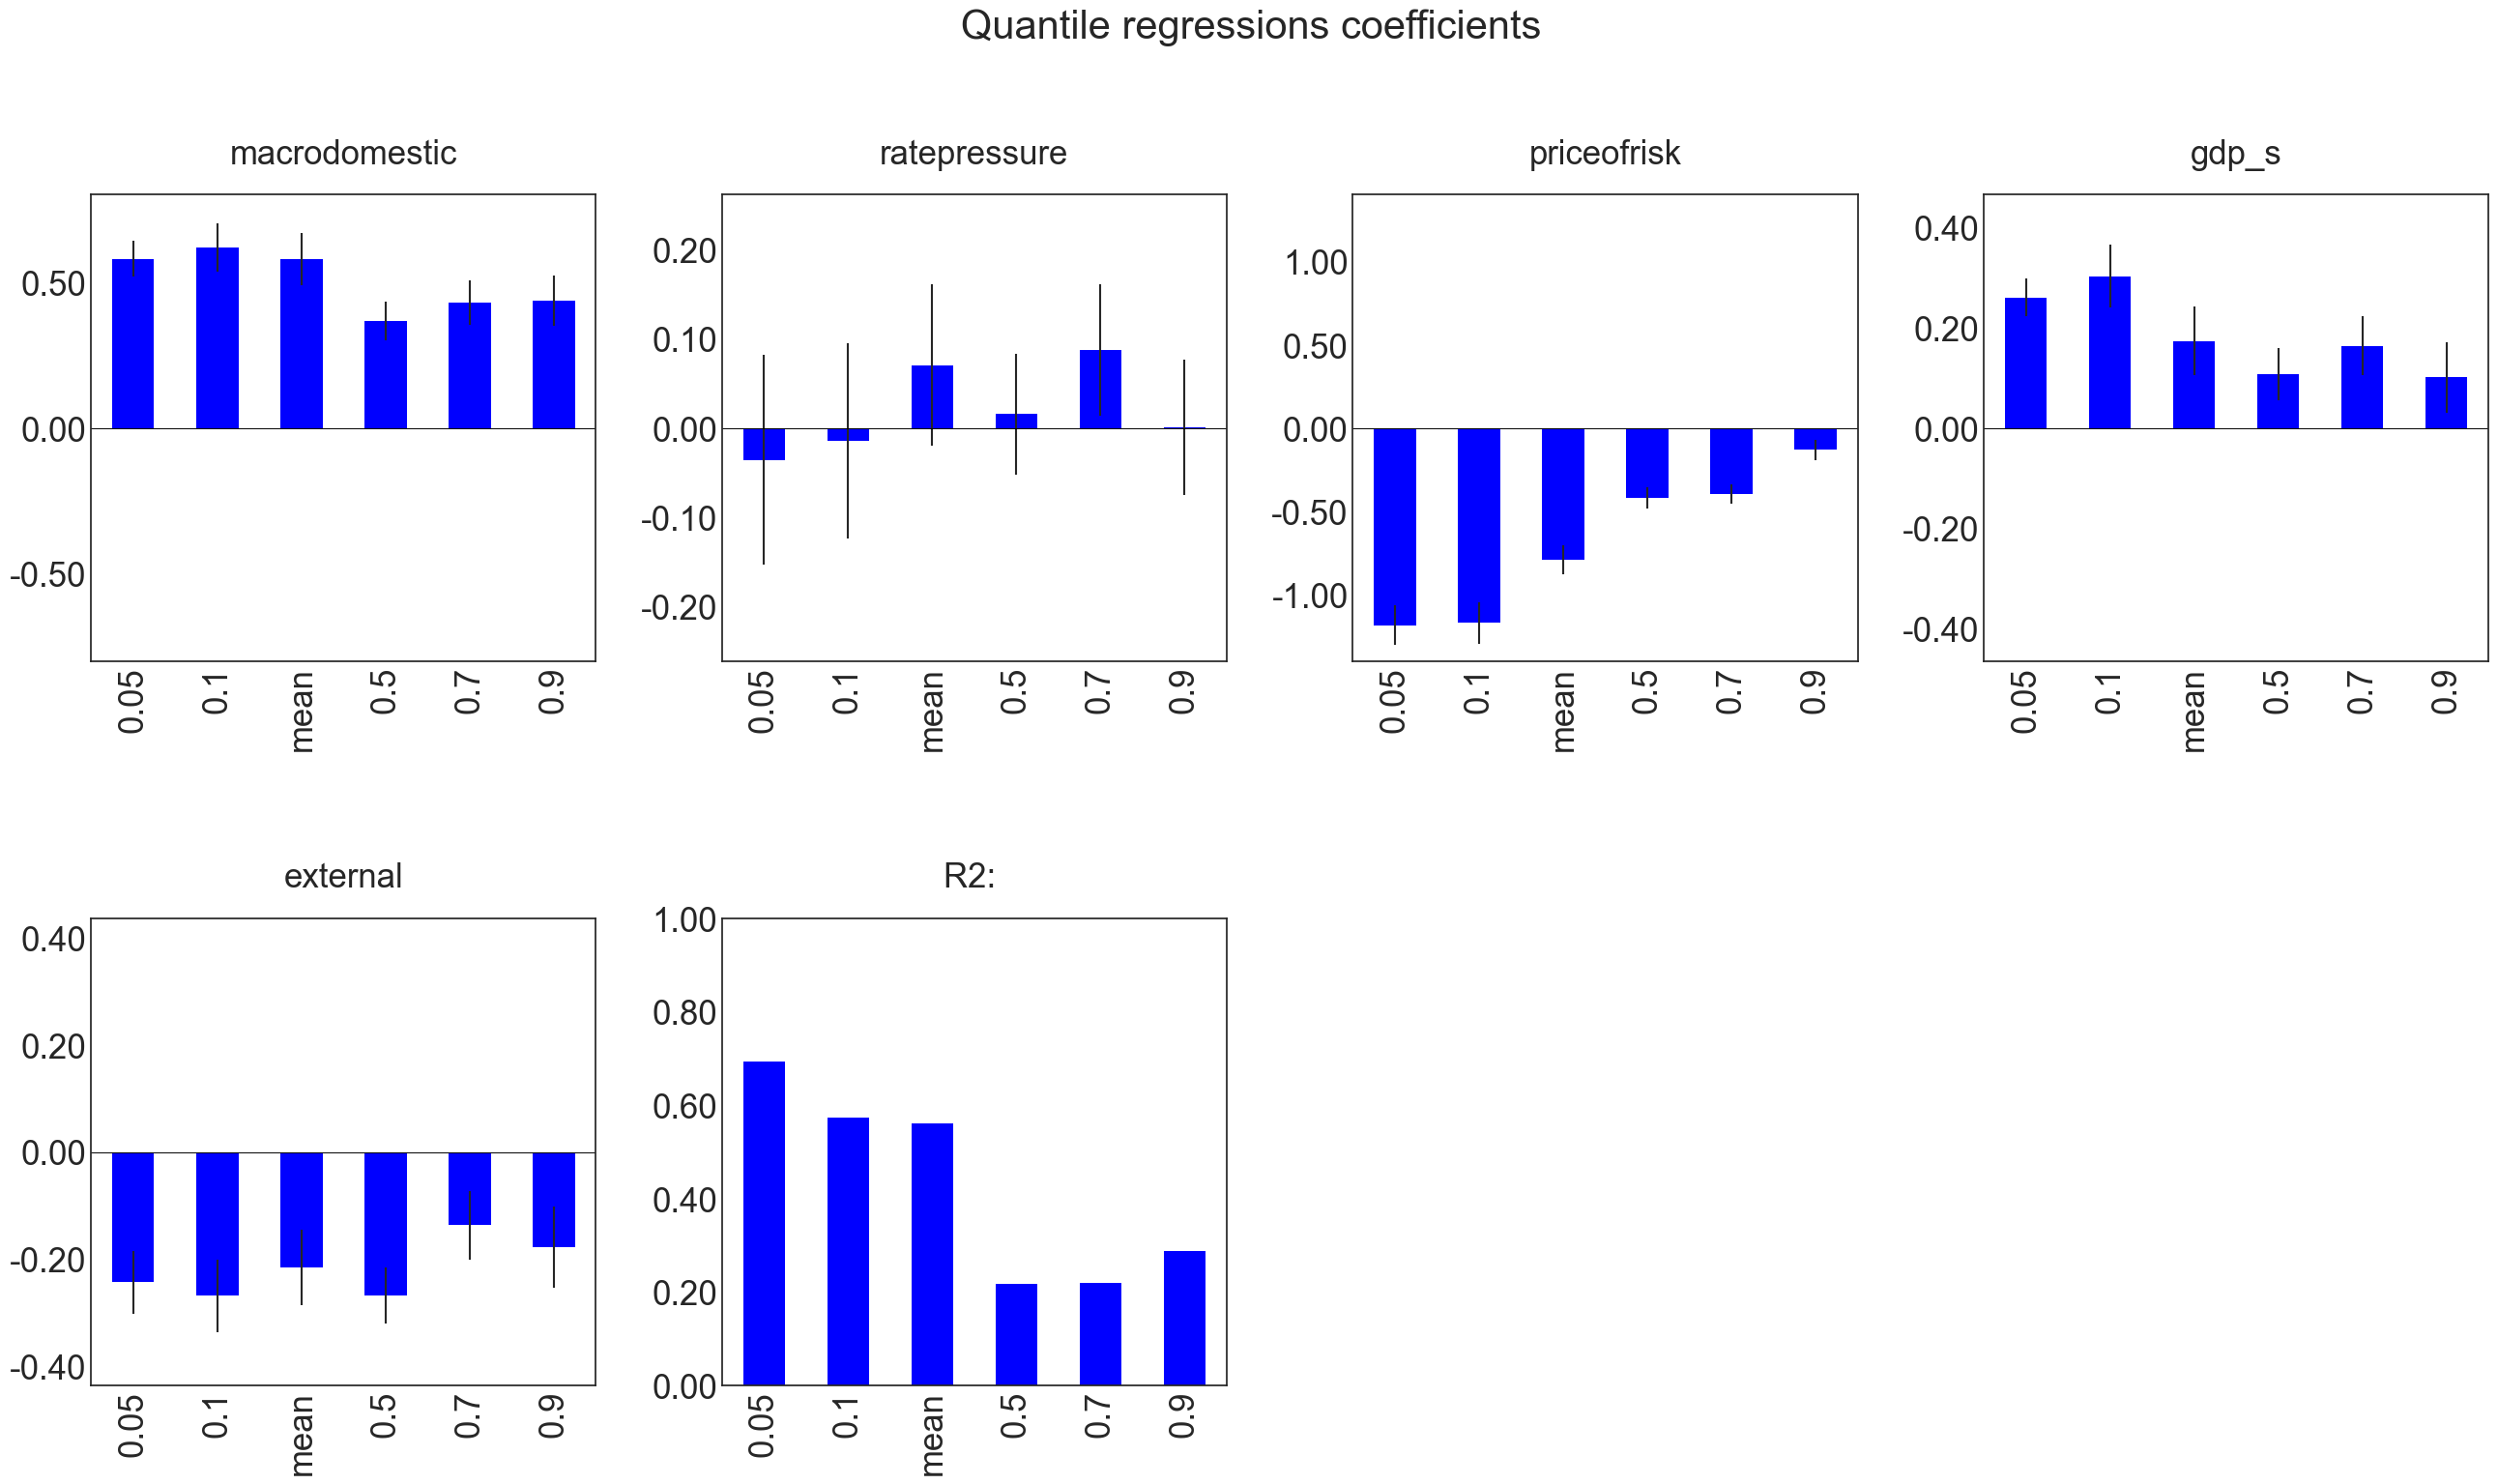

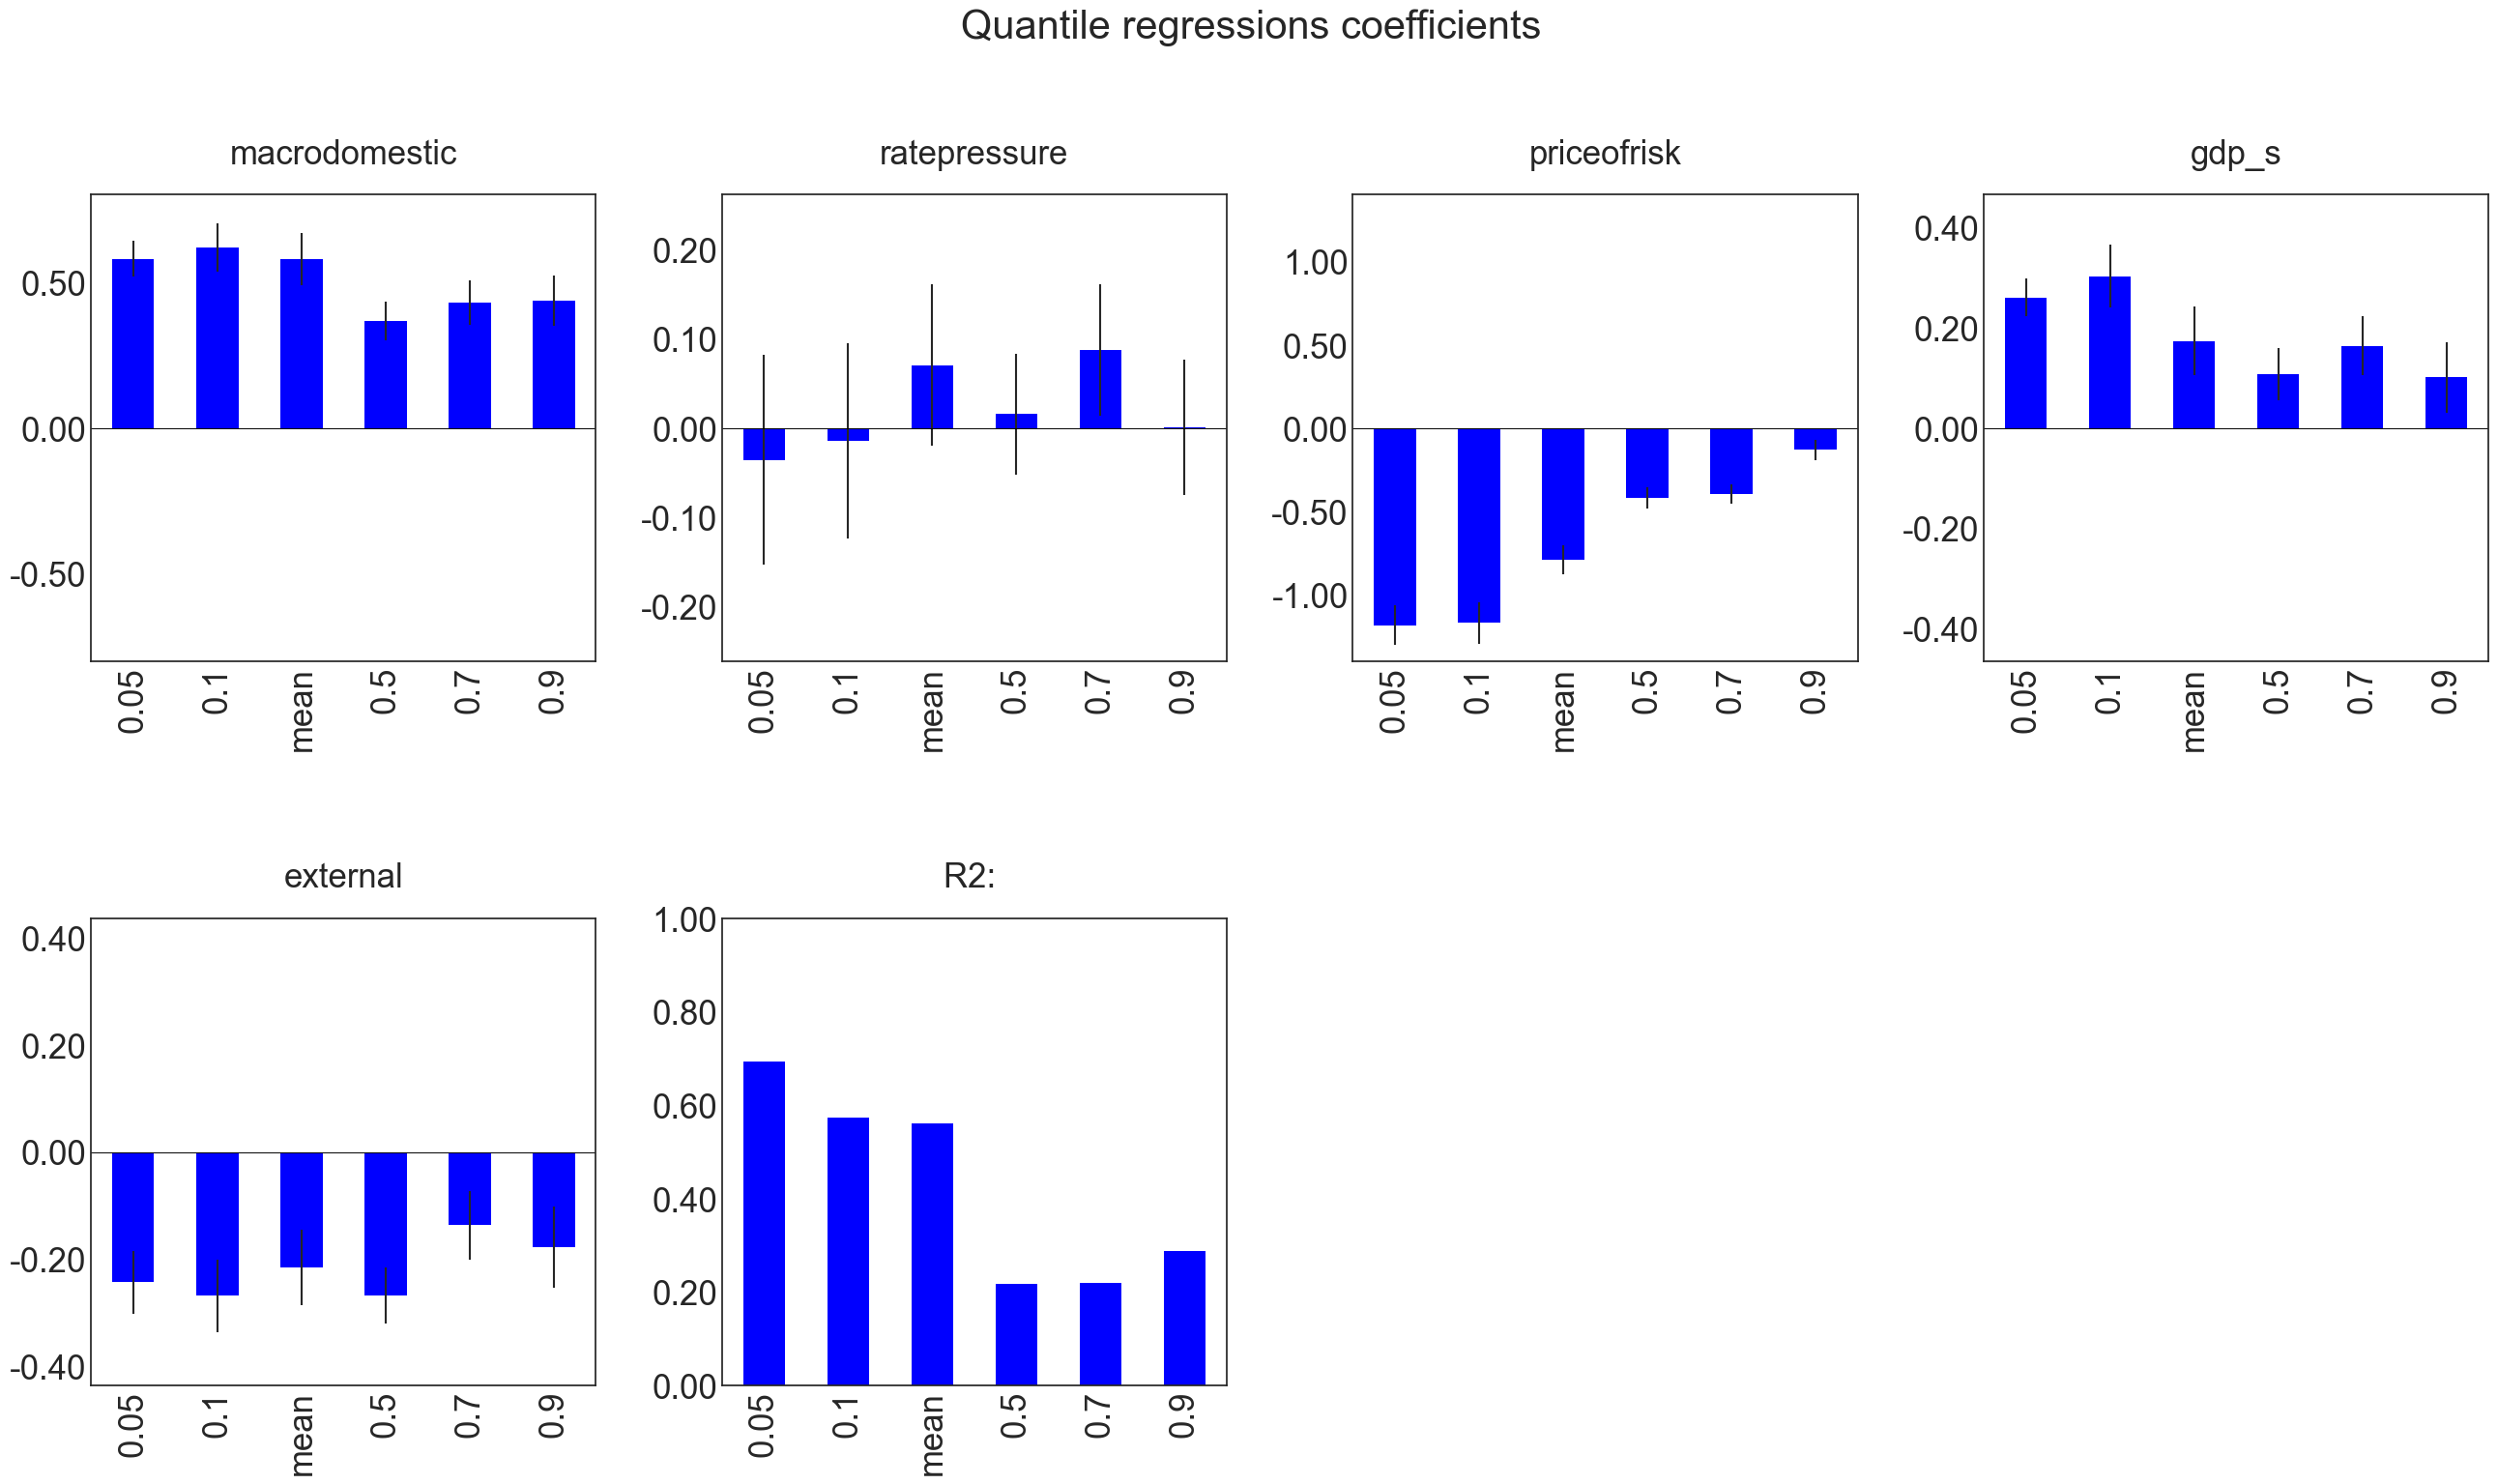

In [21]:
coeff_plot(dcoeffc = Qresult.coeff , regressors = {'external', 'gdp_s', 'priceofrisk', 'macrodomestic', 'ratepressure'}, qlist = [0.05, 0.1, 0.5, 0.7, 0.9])

In [22]:
#Chou7elwe, except for ratepressure